In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import plotly.graph_objects as go
import plotly.io as pio
import math

rcParams = {
    'xtick.labelsize': 12,
    'axes.titlesize': 22,
    'axes.labelsize': 18,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 12,
    'lines.linewidth': 2
}
sns.set_context("paper", font_scale=2, rc=rcParams)

In [2]:
# Get the colorblind palette
colorblind_palette = sns.color_palette("colorblind", n_colors=5)

method_colors = {
    'THOI': colorblind_palette[0],
    'HOI': colorblind_palette[2],
    'GCMI': colorblind_palette[4],
    # 'NPEET': colorblind_palette[1],
    'JIDT': colorblind_palette[3]
}

In [3]:
def estimated_computation_time(time_order_5, order):
    # assumes a system of 30 variables and 100000 samples
    nplet_time = time_order_5 / math.comb(30,5)
    return math.comb(30, order) * nplet_time


def get_quituplet_time_from_df(df, library, estimator):
    return df[(df.library == library) & (df.estimator == estimator) & (df['T'] == 1000) & (df.order == 5)]['time'].values[0]


def plot_estimated_computation_times(df, ax):

    quintuplet_times = {
        'HOI': get_quituplet_time_from_df(df, 'HOI', 'GC'),
        'GCMI': get_quituplet_time_from_df(df, 'GCMI', 'GC'),
        #'NPEET': get_quituplet_time_from_df(df, 'NPEET', 'KSG'),
        'JIDT': get_quituplet_time_from_df(df, 'JIDT', 'KSG')
    }

    dfs = []
    for library, tuple_t in quintuplet_times.items():
        df = pd.DataFrame({
            'time': [estimated_computation_time(tuple_t,k) for k in range(3,31)],
            'order': list(range(3,31))
        })
        df['library'] = library
        df['T'] = 1000
        df['N'] = 30
        dfs.append(df)


    # Combine all dataframes into one
    df = pd.concat(dfs, ignore_index=True)
    df['time'] = df['time']


    # Create a line plot using Seaborn
    ax = sns.lineplot(
        data=df, x="order", y="time",
        hue="library", style='library',
        markers=True, dashes=False, ax=ax,
        palette=method_colors
    )

    ax.set_xlabel('Order or interactions')
    ax.set_ylabel('Time (hours)')
    ax.legend(title='Library')
    ax.grid(True)

    for library in quintuplet_times.keys():
        print(library)
        df_lib = df[(df.library == library)]
        print('time order 15:', math.floor(df_lib[df_lib.order == 15]['time'].values[0]), 'days')
        print('time all orders:', math.floor(df_lib['time'].sum()))

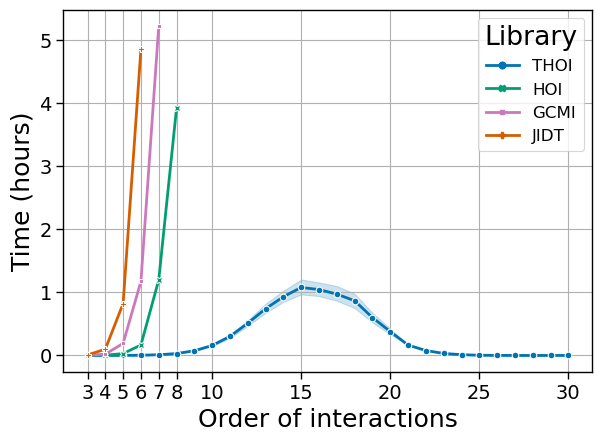

HOI
time order 15: 32 days
time all orders: 221
GCMI
time order 15: 208 days
time all orders: 1445
JIDT
time order 15: 895 days
time all orders: 6201


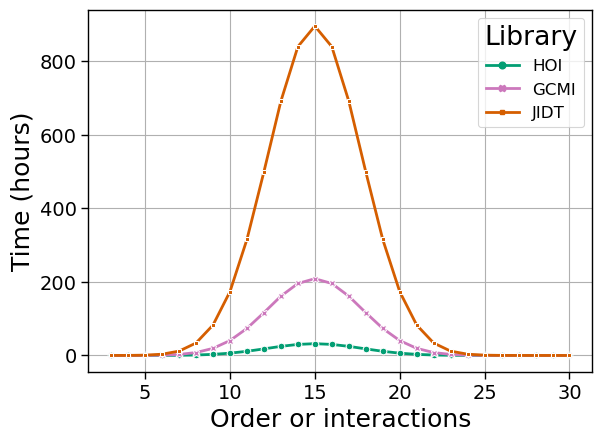

In [4]:
# Define the file paths
file_paths = [
    "library-thoi_estimator-gc_device-cpu_indexing-indexes.tsv",
    "library-hoi_estimator-gc.tsv",
    "library-gcmi_estimator-gc.tsv",
    #"library-npeet_estimator-ksg.tsv",
    "library-jdit_estimator-ksg.tsv"
]

# Read each file into a DataFrame and assign a 'Method' column
dataframes = []
for path in file_paths:
    df = pd.read_csv(os.path.join('../benchmarking/results/times/',path), sep="\t")
    dataframes.append(df)


# Combine all dataframes into one
combined_df = pd.concat(dataframes, ignore_index=True)
combined_df['time'] = combined_df['time'] / 60 / 60

# Filter the N != 30 rows
combined_df = combined_df[combined_df.N == 30]

#########################################

ax = plt.gca()

sns.lineplot(
    data=combined_df, x="order", y="time",
    hue="library", style='library',
    markers=True, dashes=False, ax=ax,
    palette=method_colors
)
ax.set_xticks([3,4,5,6,7,8,10,15,20,25,30])

ax.set_xlabel('Order of interactions')
ax.set_ylabel('Time (hours)')
ax.legend(title='Library')
ax.grid(True)

plt.tight_layout()
plt.savefig('./figures/times/benchmarking_times.pdf', format='pdf')
plt.show()

#############################################

ax = plt.gca()

plot_estimated_computation_times(combined_df, ax)

plt.tight_layout()
plt.savefig('./figures/times/benchmarking_estimated_times.pdf', format='pdf')
plt.show()

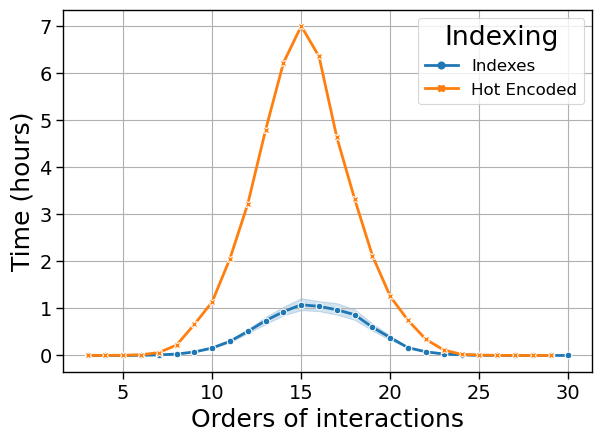

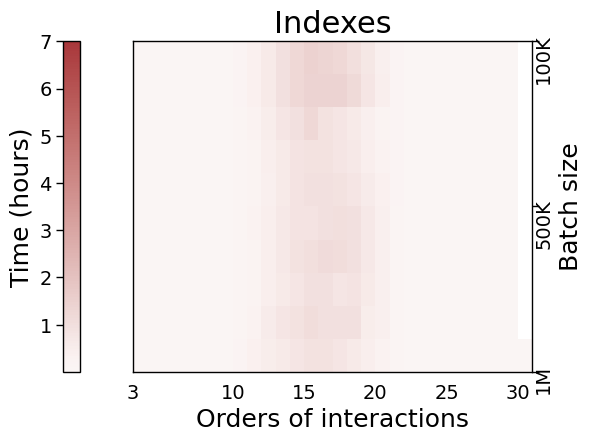

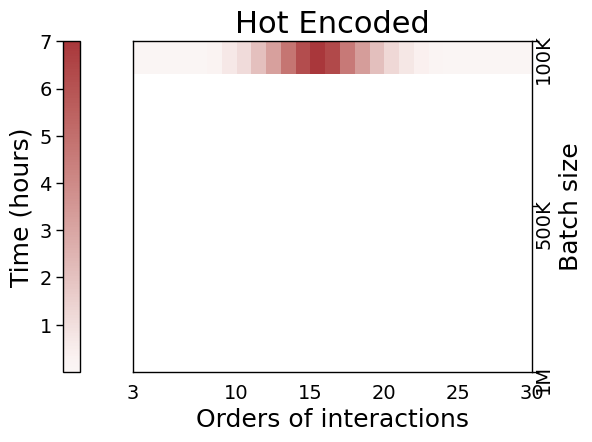

In [5]:
colorblind_palette = sns.color_palette("colorblind", n_colors=5)

indexing_colors = {
    'Indexes': colorblind_palette[0],
    'Hot Encoded': colorblind_palette[2]
}

# Define the file paths
file_paths = [
    "library-thoi_estimator-gc_device-cpu_indexing-indexes.tsv",
    "library-thoi_estimator-gc_device-cpu_indexing-hotencoded.tsv"
]

# Read each file into a DataFrame and assign a 'Method' column
dataframes = []
for path, indexing in zip(file_paths, list(indexing_colors.keys())):
    df = pd.read_csv(os.path.join('../benchmarking/results/times/',path), sep="\t")
    #df['indexing-N'] = indexing + '-' + df['N'].astype(str)
    df['indexing'] = indexing
    dataframes.append(df)

# Combine all dataframes into one
combined_df = pd.concat(dataframes, ignore_index=True)
combined_df['time'] = combined_df['time'] / 60 / 60

# Filter executions with N != 30
N = 30
combined_df = combined_df[combined_df.N == N]

#########################################

ax = sns.lineplot(
    data=combined_df, x="order", y="time",
    hue="indexing", style='indexing',
    markers=True, dashes=False,
    #palette=indexing_colors
)

ax.set_xlabel('Orders of interactions')
ax.set_ylabel('Time (hours)')
ax.legend(title='Indexing')
ax.grid(True)

plt.tight_layout()
plt.savefig('./figures/times/benchmarking_indexes_vs_hotencoded.pdf', format='pdf')
plt.show()


#########################################

max_time = combined_df['time'].max()
min_time = combined_df['time'].min()

for indexing in ['Indexes', 'Hot Encoded']:
    
    ax = plt.gca()

    df_indexes = combined_df[(combined_df.indexing == indexing)]

    # Pivot the data to get a matrix form suitable for heatmap plotting
    pivot_table = df_indexes.pivot(columns='order', index='batch_size', values="time")

    # Create the heatmap
    ax = sns.heatmap(
        pivot_table, cmap="vlag", center=0,
        annot=False, cbar=False, ax=ax,
        vmax=max_time, vmin=min_time
    )

    ax.tick_params(axis='x', rotation=90)
    ax.tick_params(left=False, bottom=False)

    # Create the colorbar and set it to the left
    cbar = ax.figure.colorbar(ax.collections[0], ax=ax, location='left')

    # Move the y-axis labels to the right
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")

    ax.set_xlabel('Orders of interactions')
    #ax.tick_params(axis='y', length=0)

    ax.set_yticks([0,5,10])
    ax.set_xticks([0,7,12,17,22,27])
    ax.set_yticklabels(['100K', '500K', '1M'], rotation=90, ha='center')
    ax.set_xticklabels([3,10,15,20,25,30], rotation=0)
    ax.set_ylabel('Batch size')
    ax.set_title(indexing)
    
    # add label to cbar
    cbar.set_label('Time (hours)')

    # add border to the heatmap
    for _, spine in ax.spines.items():
        spine.set_visible(True)

    plt.tight_layout()
    plt.savefig(f'./figures/times/benchmarking_batch_size_vs_order_{indexing.lower().replace(" ","_")}.pdf', format='pdf')
    plt.show()

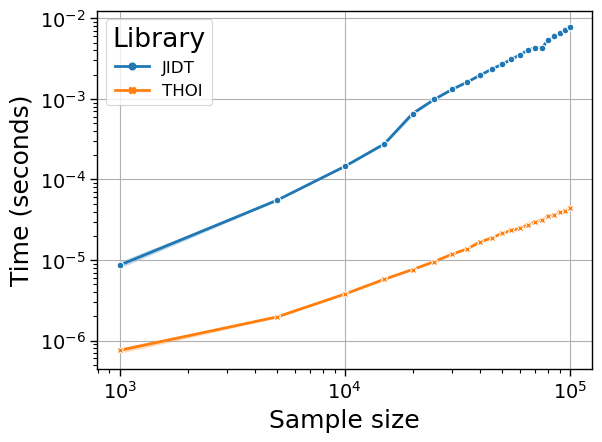

In [6]:
file_paths = [
    "by_sample_size_library-jidt.tsv",
    "by_sample_size_library-thoi.tsv",
]

libraries = [
    'JIDT',
    'THOI'
]

# Read each file into a DataFrame and assign a 'Method' column
dataframes = []
for path, library in zip(file_paths, list(libraries)):
    df = pd.read_csv(os.path.join('../benchmarking/results/times/', path), sep='\t')
    df['library'] = library
    dataframes.append(df)

# TODO: Check if times are in the same units or not

# Combine all dataframes into one
combined_df = pd.concat(dataframes, ignore_index=True)
combined_df['time'] = combined_df['time'] / 60 / 60

# plot

ax = sns.lineplot(
    data=combined_df, x="sample size", y="time",
    hue="library", style='library',
    markers=True, dashes=False,
    #palette=indexing_colors
)

# set x scale to log
ax.set_xscale('log')
ax.set_yscale('log')


ax.set_xlabel('Sample size')
ax.set_ylabel('Time (seconds)')
ax.legend(title='Library')
ax.grid(True)

plt.tight_layout()
plt.savefig('./figures/times/benchmarking_by_sample_size_thoi_vs_jidt.pdf', format='pdf')
plt.show()